In [1]:
import os
import numpy as np
import random
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
import tensorflow as tf
from skimage.util import random_noise
from skimage.color import rgb2gray, gray2rgb
from dataset_utils import crop_and_resize, combine_and_mask

In [2]:
CUB_DIR = '../data/cub-200-2011'
PLACES_DIR = '../data/val_large'
OUTPUT_DIR = '../data/dataset'
DATASET_NAME = 'places_validation_waterbird_95_decolor'
BACKGROUND_AUG = True
SEGMENTATION_AS_INPUT = False
SEGMENTATION_AS_OUTPUT = False

target_places_ids = [
    [36, 150],  # Land backgrounds ['bamboo_forest', 'forest/broadleaf']
    [243, 205]] # Water backgrounds ['ocean', 'lake/natural']

val_frac = 0.2             # What fraction of the training data to use as validation
confounder_strength = 0.95 # Determines relative size of majority vs. minority groups

In [3]:
images_path = os.path.join(CUB_DIR,'CUB_200_2011', 'CUB_200_2011', 'images.txt')

df = pd.read_csv(
    images_path,
    sep=" ",
    header=None,
    names=['img_id', 'img_filename'],
    index_col='img_id')

### Set up labels of waterbirds vs. landbirds
# We consider water birds = seabirds and waterfowl.
species = np.unique([img_filename.split('/')[0].split('.')[1].lower() for img_filename in df['img_filename']])
water_birds_list = [
    'Albatross', # Seabirds
    'Auklet',
    'Cormorant',
    'Frigatebird',
    'Fulmar',
    'Gull',
    'Jaeger',
    'Kittiwake',
    'Pelican',
    'Puffin',
    'Tern',
    'Gadwall', # Waterfowl
    'Grebe',
    'Mallard',
    'Merganser',
    'Guillemot',
    'Pacific_Loon'
]

water_birds = {}
for species_name in species:
    water_birds[species_name] = 0
    for water_bird in water_birds_list:
        if water_bird.lower() in species_name:
            water_birds[species_name] = 1
species_list = [img_filename.split('/')[0].split('.')[1].lower() for img_filename in df['img_filename']]
df['y'] = [water_birds[species] for species in species_list]

### Assign train/tesst/valid splits
# In the original CUB dataset split, split = 0 is test and split = 1 is train
# We want to change it to
# split = 0 is train,
# split = 1 is val,
# split = 2 is test

train_test_df =  pd.read_csv(
    os.path.join(CUB_DIR, 'CUB_200_2011', 'CUB_200_2011', 'train_test_split.txt'),
    sep=" ",
    header=None,
    names=['img_id', 'split'],
    index_col='img_id')

df = df.join(train_test_df, on='img_id')
test_ids = df.loc[df['split'] == 0].index
train_ids = np.array(df.loc[df['split'] == 1].index)
val_ids = np.random.choice(
    train_ids,
    size=int(np.round(val_frac * len(train_ids))),
    replace=False)

df.loc[train_ids, 'split'] = 0
df.loc[val_ids, 'split'] = 1
df.loc[test_ids, 'split'] = 50
for i in range(55, 100, 5):
    temp = df[df['split'] == 50].copy()
    temp.loc[:,'split'] = i
    df = pd.concat([df, temp], ignore_index=True, sort=False)

### Assign confounders (place categories)

# Confounders are set up as the following:
# Y = 0, C = 0: confounder_strength
# Y = 0, C = 1: 1 - confounder_strength
# Y = 1, C = 0: 1 - confounder_strength
# Y = 1, C = 1: confounder_strength

df['place'] = 0
train_ids = np.array(df.loc[df['split'] == 0].index)
val_ids = np.array(df.loc[df['split'] == 1].index)
split_list = [(0, train_ids), (1, val_ids)]
for i in range(50, 100, 5):
    split_list += [(i, np.array(df.loc[df['split'] == i].index))]
for split_idx, ids in split_list:
    for y in (0, 1):
        if split_idx == 0: # train
            if y == 0:
                pos_fraction = 1 - confounder_strength
            else:
                pos_fraction = confounder_strength
        elif split_idx == 1: # val
            if y == 0:
                pos_fraction = 1 - confounder_strength
            else:
                pos_fraction = confounder_strength
        else: #test
            temp_confounder_strength = split_idx / 100
            if y == 0:
                pos_fraction = 1 - temp_confounder_strength
            else:
                pos_fraction = temp_confounder_strength
        subset_df = df.loc[ids, :]
        y_ids = np.array((subset_df.loc[subset_df['y'] == y]).index)
        pos_place_ids = np.random.choice(
            y_ids,
            size=int(np.round(pos_fraction * len(y_ids))),
            replace=False)
        df.loc[pos_place_ids, 'place'] = 1

print_lables = [(0, 'train'), (1, 'val')]
for i in range(50, 100, 5):
    print_lables += [(i, 'test'+str(i))]
for split, split_label in print_lables:
    print(f"{split_label}:")
    split_df = df.loc[df['split'] == split, :]
    print(f"waterbirds are {np.mean(split_df['y']):.3f} of the examples")
    print(f"y = 0, c = 0: {np.mean(split_df.loc[split_df['y'] == 0, 'place'] == 0):.3f}, n = {np.sum((split_df['y'] == 0) & (split_df['place'] == 0))}")
    print(f"y = 0, c = 1: {np.mean(split_df.loc[split_df['y'] == 0, 'place'] == 1):.3f}, n = {np.sum((split_df['y'] == 0) & (split_df['place'] == 1))}")
    print(f"y = 1, c = 0: {np.mean(split_df.loc[split_df['y'] == 1, 'place'] == 0):.3f}, n = {np.sum((split_df['y'] == 1) & (split_df['place'] == 0))}")
    print(f"y = 1, c = 1: {np.mean(split_df.loc[split_df['y'] == 1, 'place'] == 1):.3f}, n = {np.sum((split_df['y'] == 1) & (split_df['place'] == 1))}")


train:
waterbirds are 0.230 of the examples
y = 0, c = 0: 0.950, n = 3506
y = 0, c = 1: 0.050, n = 185
y = 1, c = 0: 0.050, n = 55
y = 1, c = 1: 0.950, n = 1049
val:
waterbirds are 0.229 of the examples
y = 0, c = 0: 0.950, n = 878
y = 0, c = 1: 0.050, n = 46
y = 1, c = 0: 0.051, n = 14
y = 1, c = 1: 0.949, n = 261
test50:
waterbirds are 0.222 of the examples
y = 0, c = 0: 0.500, n = 2255
y = 0, c = 1: 0.500, n = 2255
y = 1, c = 0: 0.500, n = 642
y = 1, c = 1: 0.500, n = 642
test55:
waterbirds are 0.222 of the examples
y = 0, c = 0: 0.550, n = 2481
y = 0, c = 1: 0.450, n = 2029
y = 1, c = 0: 0.450, n = 578
y = 1, c = 1: 0.550, n = 706
test60:
waterbirds are 0.222 of the examples
y = 0, c = 0: 0.600, n = 2706
y = 0, c = 1: 0.400, n = 1804
y = 1, c = 0: 0.400, n = 514
y = 1, c = 1: 0.600, n = 770
test65:
waterbirds are 0.222 of the examples
y = 0, c = 0: 0.650, n = 2932
y = 0, c = 1: 0.350, n = 1578
y = 1, c = 0: 0.350, n = 449
y = 1, c = 1: 0.650, n = 835
test70:
waterbirds are 0.222 of

In [4]:
### Assign places to train, val, and test set
place_ids_df = pd.read_csv(
    os.path.join(PLACES_DIR, 'places365_val.txt'),
    sep=" ",
    header=None,
    names=['image_name', 'place_id'],
    index_col='place_id')

In [5]:
water_imgs = set()
land_imgs = set()

for i, place_type in enumerate(target_places_ids):
    for id in place_type:
        if i == 0:
            land_imgs.update(place_ids_df[place_ids_df.index == id]['image_name'])
        if i ==1:
            water_imgs.update(place_ids_df[place_ids_df.index == id]['image_name'])

In [6]:
df['water_img'] = np.random.choice(list(water_imgs), size=len(df))
df['land_img'] = np.random.choice(list(land_imgs), size=len(df))
df['place_image'] = df['place']*df['water_img'] + (1-df['place'])*df['land_img']

In [7]:
### Write dataset to disk
output_subfolder = os.path.join(OUTPUT_DIR, DATASET_NAME)
os.makedirs(output_subfolder, exist_ok=True)

for i in tqdm(df.index):
    # Load bird image and segmentation
    img_path = os.path.join(CUB_DIR, 'CUB_200_2011', 'CUB_200_2011', 'images', df.loc[i, 'img_filename'])
    seg_path = os.path.join(CUB_DIR, 'segmentations', df.loc[i, 'img_filename'].replace('.jpg','.png'))
    img_np = np.asarray(Image.open(img_path).convert('RGB'))
    seg_img = Image.open(seg_path).convert('RGB')
    seg_np = np.asarray(seg_img) / 255

    # Load place background
    # Skip front /
    place_path = os.path.join(PLACES_DIR, df.loc[i, 'place_image'])
    place = Image.open(place_path).convert('RGB')

    if BACKGROUND_AUG:
        if df.loc[i, 'split'] == 0:
            # place = gray2rgb(rgb2gray(np.array(place)))
            # place = random_noise(np.array(place), mode='gaussian', mean=0, var=0.05, clip=True)   
            # place = random_noise(np.array(place), mode='s&p', salt_vs_pepper=0.5, clip=True)
            # place = random_noise(np.array(place), mode='speckle', mean=0, var=0.05, clip=True)
            place = gray2rgb(np.array(place) @ [1/3, 1/3, 1/3])
            place = Image.fromarray((place).astype(np.uint8)) 

    img_black = Image.fromarray(np.around(img_np * seg_np).astype(np.uint8))
    combined_img = combine_and_mask(place, seg_np, img_black)


    if SEGMENTATION_AS_INPUT:
        combined_img.putalpha(seg_img.convert("L"))

    label_folder = ''
    if df.loc[i, 'y'] == 1:
        label_folder = 'waterbird'
    if df.loc[i, 'y'] == 0:
        label_folder = 'landbird'

    split_folder = ''
    if df.loc[i, 'split'] == 0:
        split_folder = 'train'
    elif df.loc[i, 'split'] == 1:
        split_folder = 'val'
    else:
        split_folder = 'test'+str(df.loc[i, 'split'])
    img_path_name = df.loc[i, 'img_filename'].split('/')[-1]

    if SEGMENTATION_AS_OUTPUT:
        output_path = os.path.join(output_subfolder, split_folder, 'image', img_path_name).replace('.jpg','.png')
        os.makedirs(os.path.join(output_subfolder, split_folder, 'image'), exist_ok=True)
        seg_output_path = os.path.join(output_subfolder, split_folder, 'mask', img_path_name).replace('.jpg','.png')
        os.makedirs(os.path.join(output_subfolder, split_folder, 'mask'), exist_ok=True)
        seg_img.save(seg_output_path)
    else:
        output_path = os.path.join(output_subfolder, split_folder, label_folder, img_path_name).replace('.jpg','.png')
        os.makedirs(os.path.join(output_subfolder, split_folder, label_folder), exist_ok=True)

    combined_img.save(output_path)
    df.loc[i, 'img_filename'] = output_path

df.to_csv(os.path.join(output_subfolder, 'metadata.csv'))

100%|██████████| 63934/63934 [9:47:34<00:00,  1.81it/s]        


In [86]:
# type_subfolder = os.path.join(OUTPUT_DIR, "water")
# os.makedirs(type_subfolder, exist_ok=True)

# for img in water_imgs:
#     place_path = os.path.join(PLACES_DIR, img)
#     output_path = os.path.join(type_subfolder, img)
#     place = Image.open(place_path).convert('RGB')
#     place.save(output_path)

In [87]:
# type_subfolder = os.path.join(OUTPUT_DIR, "land")
# os.makedirs(type_subfolder, exist_ok=True)

# for img in land_imgs:
#     place_path = os.path.join(PLACES_DIR, img)
#     output_path = os.path.join(type_subfolder, img)
#     place = Image.open(place_path).convert('RGB')
#     place.save(output_path)

In [91]:
water_img = "Places365_val_00000906.jpg"
bird = "012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0008_8756.jpg"
output_subfolder = os.path.join(OUTPUT_DIR, "test")
os.makedirs(output_subfolder, exist_ok=True)

# Load bird image and segmentation
img_path = os.path.join(CUB_DIR, 'CUB_200_2011', 'CUB_200_2011', 'images', bird)
seg_path = os.path.join(CUB_DIR, 'segmentations', bird.replace('.jpg','.png'))
img_np = np.asarray(Image.open(img_path).convert('RGB'))
seg_np = np.asarray(Image.open(seg_path).convert('RGB')) / 255

# Load place background
# Skip front /
place_path = os.path.join(PLACES_DIR, water_img)
place = Image.open(place_path).convert('RGB')

img_black = Image.fromarray(np.around(img_np * seg_np).astype(np.uint8))
combined_img = combine_and_mask(place, seg_np, img_black)
output_path = os.path.join(output_subfolder, "original.jpg")
combined_img.save(output_path)

gaussian_place = random_noise(np.array(place), mode='gaussian', mean=0, var=0.05, clip=True) 
gaussian_place = Image.fromarray((gaussian_place * 255).astype(np.uint8)) 
combined_img = combine_and_mask(gaussian_place, seg_np, img_black)
output_path = os.path.join(output_subfolder, "gaussian.jpg")
combined_img.save(output_path)

sandp_place = random_noise(np.array(place), mode='s&p', salt_vs_pepper=0.5, clip=True)
sandp_place = Image.fromarray((sandp_place * 255).astype(np.uint8)) 
combined_img = combine_and_mask(sandp_place, seg_np, img_black)
output_path = os.path.join(output_subfolder, "sandp.jpg")
combined_img.save(output_path)

speckle_place = random_noise(np.array(place), mode='speckle', mean=0, var=0.05, clip=True)
speckle_place = Image.fromarray((speckle_place * 255).astype(np.uint8)) 
combined_img = combine_and_mask(speckle_place, seg_np, img_black)
output_path = os.path.join(output_subfolder, "speckle.jpg")
combined_img.save(output_path)

gray_place = gray2rgb(rgb2gray(np.array(place)))
gray_place = Image.fromarray((gray_place * 255).astype(np.uint8)) 
combined_img = combine_and_mask(gray_place, seg_np, img_black)
output_path = os.path.join(output_subfolder, "gray.jpg")
combined_img.save(output_path)

blur_place = place.filter(ImageFilter.BLUR)
combined_img = combine_and_mask(blur_place, seg_np, img_black)
output_path = os.path.join(output_subfolder, "blur.jpg")
combined_img.save(output_path)

decolor_place = gray2rgb(np.array(place) @ [1/3, 1/3, 1/3])
decolor_place = Image.fromarray((decolor_place).astype(np.uint8)) 
combined_img = combine_and_mask(decolor_place, seg_np, img_black)
output_path = os.path.join(output_subfolder, "decolor.jpg")
combined_img.save(output_path)

# place = gray2rgb(rgb2gray(np.array(place)))
        # place = random_noise(np.array(place), mode='s&p', salt_vs_pepper=0.5, clip=True)
        # place = random_noise(np.array(place), mode='speckle', mean=0, var=0.05, clip=True)
        # place = Image.fromarray((place * 255).astype(np.uint8))  

In [92]:
import random
import scipy.spatial.distance as dist
from PIL import ImageOps

def fit(img, size=(224, 224)):
    return ImageOps.fit(img, size)

land_img_sample = random.sample(land_imgs, 100)
water_img_sample = random.sample(water_imgs, 100)
dist_list = []
gaussian_dist_list = []
gray_dist_list = []
decolor_dist_list = []

for land_img, water_img in zip(land_img_sample, water_img_sample):
    land_path = os.path.join(PLACES_DIR, land_img)
    land_img = Image.open(land_path).convert('RGB')


    water_path = os.path.join(PLACES_DIR, water_img)
    water_img = Image.open(water_path).convert('RGB')
    dist_list.append(dist.euclidean(np.asarray(fit(land_img)).flatten(), np.asarray(fit(water_img)).flatten()))

    temp1 = random_noise(np.asarray(fit(land_img)), mode='gaussian', mean=0, var=0.05, clip=True) * 255
    temp2 = random_noise(np.asarray(fit(water_img)), mode='gaussian', mean=0, var=0.05, clip=True) * 255
    gaussian_dist_list.append(dist.euclidean(temp1.flatten(),temp2.flatten()))

    temp1 = gray2rgb(rgb2gray(np.asarray(fit(land_img)))) * 255
    temp2 = gray2rgb(rgb2gray(np.asarray(fit(water_img)))) * 255
    gray_dist_list.append(dist.euclidean(temp1.flatten(),temp2.flatten()))

    temp1 = gray2rgb(np.asarray(fit(land_img)) @ [1/3, 1/3, 1/3])
    temp2 = gray2rgb(np.asarray(fit(water_img)) @ [1/3, 1/3, 1/3])
    decolor_dist_list.append(dist.euclidean(temp1.flatten(),temp2.flatten()))
    
    

    

<AxesSubplot:xlabel='Distance', ylabel='Count'>

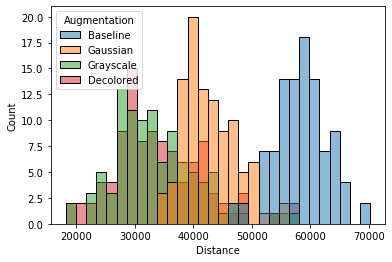

In [94]:
import seaborn as sns

l = len(dist_list)
dist_df = pd.DataFrame({'Distance': dist_list + gaussian_dist_list + gray_dist_list + decolor_dist_list,
                        'Augmentation': ["Baseline"]*l + ["Gaussian"]*l + ['Grayscale']*l + ["Decolored"]*l})

sns.histplot(data=dist_df, x='Distance', hue='Augmentation', bins=30)